In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import gto, scf
import pyqmc.api as pyq
import h5py
import matplotlib.pyplot as plt
from ase.data.pubchem import pubchem_atoms_search
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

# Here we reset the files
for fname in ['mf.hdf5','optimized_wf.hdf5','vmc_data.hdf5','dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

In [2]:
from ase.collections import g2
print(g2.names)
from ase.build.molecule import extra
print(extra.keys())

['PH3', 'P2', 'CH3CHO', 'H2COH', 'CS', 'OCHCHO', 'C3H9C', 'CH3COF', 'CH3CH2OCH3', 'HCOOH', 'HCCl3', 'HOCl', 'H2', 'SH2', 'C2H2', 'C4H4NH', 'CH3SCH3', 'SiH2_s3B1d', 'CH3SH', 'CH3CO', 'CO', 'ClF3', 'SiH4', 'C2H6CHOH', 'CH2NHCH2', 'isobutene', 'HCO', 'bicyclobutane', 'LiF', 'Si', 'C2H6', 'CN', 'ClNO', 'S', 'SiF4', 'H3CNH2', 'methylenecyclopropane', 'CH3CH2OH', 'F', 'NaCl', 'CH3Cl', 'CH3SiH3', 'AlF3', 'C2H3', 'ClF', 'PF3', 'PH2', 'CH3CN', 'cyclobutene', 'CH3ONO', 'SiH3', 'C3H6_D3h', 'CO2', 'NO', 'trans-butane', 'H2CCHCl', 'LiH', 'NH2', 'CH', 'CH2OCH2', 'C6H6', 'CH3CONH2', 'cyclobutane', 'H2CCHCN', 'butadiene', 'C', 'H2CO', 'CH3COOH', 'HCF3', 'CH3S', 'CS2', 'SiH2_s1A1d', 'C4H4S', 'N2H4', 'OH', 'CH3OCH3', 'C5H5N', 'H2O', 'HCl', 'CH2_s1A1d', 'CH3CH2SH', 'CH3NO2', 'Cl', 'Be', 'BCl3', 'C4H4O', 'Al', 'CH3O', 'CH3OH', 'C3H7Cl', 'isobutane', 'Na', 'CCl4', 'CH3CH2O', 'H2CCHF', 'C3H7', 'CH3', 'O3', 'P', 'C2H4', 'NCCN', 'S2', 'AlCl3', 'SiCl4', 'SiO', 'C3H4_D2d', 'H', 'COF2', '2-butyne', 'C2H5', 'BF3'

In [14]:
from pyscf import scf
mol_h2o = gto.M(atom = 'O 0 0 0; H 0 1 0; H 0 0 1', basis = 'ccpvdz')
rhf_h2o = scf.RHF(mol_h2o)
e_h2o = rhf_h2o.kernel()

converged SCF energy = -76.0167894720692


In [16]:

def mean_field(chkfile):
    atoms =  pubchem_atoms_search(name='water')
    # from ase import Atoms
    # # d = 1.1
    # # co = Atoms('CO', positions=[(0, 0, 0), (0, 0, d)])
    # pos = [
    #     (-0.41050479500000, -0.02822011359072, -0.61865600306683), 
    #     (-0.41050479500000,1.99057945949862, 0.10790294909375)
    #     ]
    # atoms = Atoms('FeS', pos)  # -1667 Hartrees
    
    mol = gto.M(
        atom=pyscf_ase.ase_atoms_to_pyscf(atoms),
        basis = 'ccpvdz'
    )
    mf = scf.RHF(mol)
    mf.chkfile = chkfile
    mf.kernel()

mean_field("mf.hdf5")

pyq.OPTIMIZE(
    "mf.hdf5",           # Construct a Slater-Jastrow wave function from the pyscf output
    "optimized_wf.hdf5", # Store optimized parameters in this file.
    nconfig=100,         # Optimize using this many Monte Carlo samples/configurations
    max_iterations=10,   # 10 optimization steps
    verbose=True
    )

df = pyq.read_opt("optimized_wf.hdf5")
print(df)


converged SCF energy = -76.0259894063648
starting warmup
---vmc done
finished warmup
----------vmc done
descent en -101.13529362865327 0.5796428563089683  estimated sigma  57.96428563089683
descent |grad| 17.01035370751467
----------vmc done
descent en -97.58549261981548 0.1383224320269355  estimated sigma  13.832243202693551
descent |grad| 26.766160277614414
----------vmc done
descent en -103.90292602470852 4.520181142938934  estimated sigma  452.0181142938934
descent |grad| 167.2618309781129
----------vmc done
descent en 49.07286339359655 9.863571906758967  estimated sigma  986.3571906758967
descent |grad| 154.67578272474654
----------vmc done
descent en -27.716268348107626 3.21018846534349  estimated sigma  321.018846534349
descent |grad| 76.16062243053305
----------vmc done
descent en -47.04025707423333 12.53851979919566  estimated sigma  1253.851979919566
descent |grad| 607.0434087809106
----------vmc done
descent en -7.342640430867891 4.260756104912589  estimated sigma  426.07561

KeyboardInterrupt: 

In [12]:
-76 / -17.064928006778427 


13.61 

4.4535787065618875

In [10]:

with h5py.File("optimized_wf.hdf5") as f:
    print("keys", list(f.keys()))
    print("wave function parameters", list(f['wf'].keys()))
    print(f['wf/wf2bcoeff'][()])

pyq.VMC(
    "mf.hdf5",                            #Construct a Slater-Jastrow wave function from this file
    "vmc_data.hdf5",                      #Store Monte Carlo data in this file
    load_parameters="optimized_wf.hdf5", #Load optimized parameters from this file
    nblocks=30,                           #Run for 30 blocks. By default, there are 10 steps per block and 1000 configurations
    verbose=True
    )

pyq.read_mc_output("vmc_data.hdf5")


keys ['configs', 'energy', 'energy_error', 'est_min', 'iteration', 'nconfig', 'pgradient', 'tau', 'wf', 'x', 'yfit']
wave function parameters ['wf2acoeff', 'wf2bcoeff']
[[-0.25       -0.5        -0.25      ]
 [ 0.0419967   0.04133952  0.03825168]
 [-0.13702907 -0.26074258 -0.14264762]
 [-0.12726007 -0.13692625 -0.11740974]]
------------------------------vmc done


{'fname': 'vmc_data.hdf5',
 'warmup': 1,
 'reblock': None,
 'acceptance': 0.5960129310344826,
 'acceptance_err': 0.0011434977754205366,
 'energyecp': 1.2483304405365818,
 'energyecp_err': 0.010178561670557494,
 'energyee': 17.104863100284064,
 'energyee_err': 0.014472777093208171,
 'energyei': -55.41418809033711,
 'energyei_err': 0.03671205259712123,
 'energygrad2': 25.927714741170472,
 'energygrad2_err': 0.15635692825276343,
 'energyke': 13.09615293453345,
 'energyke_err': 0.022833963607181696,
 'energytotal': -17.064928006778427,
 'energytotal_err': 0.004973795622867411}

----------vmc done
eref start -17.192471365209855 esigma 0.6060084566788402
energy -17.157144470191746 e_trial -17.157228021762993 e_est -17.157144470191746 sigma(w) 0.028121692186981673
energy -17.344268092247443 e_trial -17.256326213115855 e_est -17.250953702916675 sigma(w) 0.0330978784312599
energy -17.259404482932535 e_trial -17.26778521394214 e_est -17.253791818373227 sigma(w) 0.04143125195867796
energy -17.40644270587499 e_trial -17.36597716413347 e_est -17.3370329027962 sigma(w) 0.0516052550073507
energy -17.43129645519727 e_trial -17.40214139507521 e_est -17.3610424776499 sigma(w) 0.01746554421569447
energy -17.456741270793692 e_trial -17.424460863159332 e_est -17.380513577220036 sigma(w) 0.033640124772223466
energy -17.414828294497763 e_trial -17.429154365739393 e_est -17.38630965249341 sigma(w) 0.032293753018377655
energy -17.563422198214667 e_trial -17.469484192182147 e_est -17.422926451459464 sigma(w) 0.02646388732300086
energy -17.354273648027046 e_trial -17.4609495330722 

Text(0, 0.5, 'Energy (Hartree)')

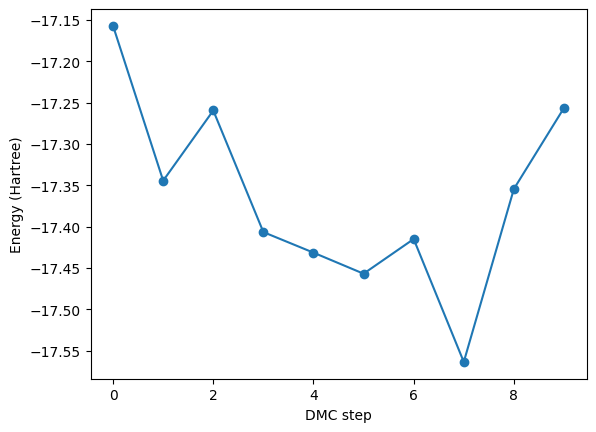

In [7]:

pyq.DMC(
    "mf.hdf5",
    "dmc.hdf5",                            #Initialize the Slater-Jastrow wave function using pyscf
    load_parameters=f"optimized_wf.hdf5",  #Load the optimized parameters
    verbose=True,
    tstep=.1,                              #timestep of 0.1 Hartrees^-1
    nsteps=int(1/.1),                      #propagate for 50 Hartrees^-1
    branchtime=1,                          #Efficiency parameter; these are 'mini-blocks'
    nconfig=10                             #Use 1,000 configurations
    )                         

with h5py.File("dmc.hdf5") as f:
    en = f['energytotal'][...]

plt.plot(en, marker='o')
plt.xlabel("DMC step")
plt.ylabel("Energy (Hartree)")
